In [2]:
!pip install bz2file
!pip install tqdm
!pip install nltk

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import bz2
import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


%matplotlib inline

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pedalv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# existe uma api do proprio kaggle para download de seus datasets, entretanto é preciso configuracao de credencial 
# oque nao seria viavel dentro de um notebook, pedimos entao que por favor faça o download do dataset e bote na
# pasta do projeto

# https://www.kaggle.com/bittlingmayer/amazonreviews/downloads/amazonreviews.zip/2

import zipfile
zip_ref = zipfile.ZipFile('amazonreviews.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
file = bz2.BZ2File('train.ft.txt.bz2')

In [4]:
file_lines = file.readlines()

file_lines = [x.decode('utf-8') for x in file_lines]

In [5]:
file_lines[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

Utilizamos um tamanho reduzido do dataset devido ao altissimo valor de memoria allocada e tempo de processamento para o dataset completo

In [6]:
temp = []
for line in tqdm.tqdm(file_lines[:500000]):
    text = re.sub('__label__', '', line)
    sentiment = int(text[0]) - 1
    clean_text = re.sub("[^a-zA-Z]"," ", text[1:])
        
    temp.append([clean_text, sentiment])

 84%|████████▍ | 420739/500000 [00:10<00:01, 42073.77it/s]/home/pedalv/miniconda3/envs/jupyter/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 500000/500000 [00:11<00:00, 41986.92it/s]


In [7]:
df = pd.DataFrame(temp, columns=['Review', 'Sentiment'])
df.head()

,Review,Sentiment
0,Stuning even for the non gamer This sound tr...,1
1,The best soundtrack ever to anything I m re...,1
2,Amazing This soundtrack is my favorite musi...,1
3,Excellent Soundtrack I truly like this sound...,1
4,Remember Pull Your Jaw Off The Floor After H...,1


Conferimos se nosso dataset se encontra balanceado, ou seja, um numero similar entre reviews negativos e positivos

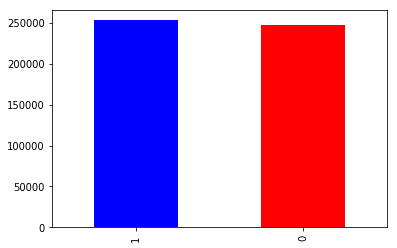

In [8]:
df['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'red'])

# Cleaning Text

Para o tratamento do texto optamos por deixar todas as letras minusculas, remover as stopwords, uma vez que nao seriam relevantes para o nosso Bag of Words, e fazer o steaming das palavras, reduzindo assim a palavra ao seu radical facilitando nosso bag of words, uma vez que contabilizara o radical das palavras e nao uma forma especifica dela

In [9]:
corpus = []
ps = PorterStemmer()

for i in tqdm.tqdm(range(0, df.shape[0])):
    review = df['Review'][i]

    # lower cases
    review = review.lower()

    # steming and removing stopwords words 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 1200/500000 [00:09<1:08:31, 121.31it/s]/home/pedalv/miniconda3/envs/jupyter/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 500000/500000 [1:07:37<00:00, 123.22it/s]


In [10]:
print(corpus[0])

stune even non gamer sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen


In [11]:
df['Review'][0]

' Stuning even for the non gamer  This sound track was beautiful  It paints the senery in your mind so well I would recomend it even to people who hate vid  game music  I have played the game Chrono Cross but out of all of the games I have ever played it has the best music  It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  It would impress anyone who cares to listen      '

# Creating the Bag of Words model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# utilizamos as 1500 palavras mais frequentes
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 1].values

Quais seriam as palavras mais frequentes encontradas em nosso corpus?

In [35]:
freqs = X.sum(axis=0)
words_freq = [(word, freqs[idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [37]:
words_freq[:10]

[('book', 337529),
 ('one', 208580),
 ('like', 173347),
 ('read', 159394),
 ('good', 150582),
 ('great', 150399),
 ('movi', 148705),
 ('time', 125097),
 ('get', 123106),
 ('would', 115255)]

# Split data


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# Decision tree

Para a comparacao entre nosso modelo de Deep Learning decidimos usar uma decision tree. O resultado que esperamos seria algo relativamente menor ao resultado do Deep Learning

In [17]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
y_pred = classifier.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error
acc = 1 - mean_absolute_error(y_test, y_pred.astype(int))

acc

0.7643

Como esperado obtivemos um resultado de 76.43%, menor do que o do Deep Learning